# Practice lab: Deep Learning for Content-Based Filtering

In this exercise, you will implement content-based filtering using a neural network to build a recommender system for movies. 


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Movie ratings dataset ](#2)
- [ 3 - Content-based filtering with a neural network](#3)
  - [ 3.1 Training Data](#3.1)
  - [ 3.2 Preparing the training data](#3.2)
- [ 4 - Neural Network for content-based filtering](#4)
  - [ Exercise 1](#ex01)
- [ 5 - Predictions](#5)
  - [ 5.1 - Predictions for a new user](#5.1)
  - [ 5.2 - Predictions for an existing user.](#5.2)
  - [ 5.3 - Finding Similar Items](#5.3)
    - [ Exercise 2](#ex02)
- [ 6 - Congratulations! ](#6)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this lab. Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 
We will use familiar packages, NumPy, TensorFlow and helpful routines from [scikit-learn](https://scikit-learn.org/stable/). We will also use [tabulate](https://pypi.org/project/tabulate/) to neatly print tables and [Pandas](https://pandas.pydata.org/) to organize tabular data.

In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
from recsysNN_utils import *
pd.set_option("display.precision", 1)

<a name="2"></a>
## 2 - Movie ratings dataset
The data set is derived from the [MovieLens ml-latest-small](https://grouplens.org/datasets/movielens/latest/) dataset. 

[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

The original dataset has roughly 9000 movies rated by 600 users with ratings on a scale of 0.5 to 5 in 0.5 step increments. The dataset has been reduced in size to focus on movies from the years since 2000 and popular genres. The reduced dataset has $n_u = 397$ users, $n_m= 847$ movies and 25521 ratings. For each movie, the dataset provides a movie title, release date, and one or more genres. For example "Toy Story 3" was released in 2010 and has several genres: "Adventure|Animation|Children|Comedy|Fantasy". This dataset contains little information about users other than their ratings. This dataset is used to create training vectors for the neural networks described below. 
Let's learn a bit more about this data set. The table below shows the top 10 movies ranked by the number of ratings. These movies also happen to have high average ratings. How many of these movies have you watched? 

In [3]:
top10_df = pd.read_csv("./data/content_top10_df.csv")
bygenre_df = pd.read_csv("./data/content_bygenre_df.csv")
top10_df

,movie id,num ratings,ave rating,title,genres
0,4993,198,4.1,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,5952,188,4.0,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy
2,7153,185,4.1,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
3,4306,170,3.9,Shrek,Adventure|Animation|Children|Comedy|Fantasy|Ro...
4,58559,149,4.2,"Dark Knight, The",Action|Crime|Drama
5,6539,149,3.8,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
6,79132,143,4.1,Inception,Action|Crime|Drama|Mystery|Sci-Fi|Thriller
7,6377,141,4.0,Finding Nemo,Adventure|Animation|Children|Comedy
8,4886,132,3.9,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
9,7361,131,4.2,Eternal Sunshine of the Spotless Mind,Drama|Romance|Sci-Fi


The next table shows information sorted by genre. The number of ratings per genre vary substantially. Note that a movie may have multiple genre's so the sum of the ratings below is larger than the number of original ratings.

In [4]:
bygenre_df

,genre,num movies,ave rating/genre,ratings per genre
0,Action,321,3.4,10377
1,Adventure,234,3.4,8785
2,Animation,76,3.6,2588
3,Children,69,3.4,2472
4,Comedy,326,3.4,8911
5,Crime,139,3.5,4671
6,Documentary,13,3.8,280
7,Drama,342,3.6,10201
8,Fantasy,124,3.4,4468
9,Horror,56,3.2,1345


<a name="3"></a>
## 3 - Content-based filtering with a neural network

In the collaborative filtering lab, you generated two vectors, a user vector and an item/movie vector whose dot product would predict a rating. The vectors were derived solely from the ratings.   

Content-based filtering also generates a user and movie feature vector but recognizes there may be other information available about the user and/or movie that may improve the prediction. The additional information is provided to a neural network which then generates the user and movie vector as shown below.

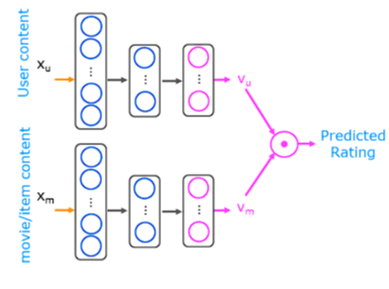

<a name="3.1"></a>
### 3.1 Training Data
The movie content provided to the network is a combination of the original data and some 'engineered features'. Recall the feature engineering discussion and lab from Course 1, Week 2, lab 4. The original features are the year the movie was released and the movie's genre's presented as a one-hot vector. There are 14 genres. The engineered feature is an average rating derived from the user ratings. 

The user content is composed of engineered features. A per genre average rating is computed per user. Additionally, a user id, rating count and rating average are available but not included in the training or prediction content. They are carried with the data set because they are useful in interpreting data.

The training set consists of all the ratings made by the users in the data set. Some ratings are repeated to boost the number of training examples of underrepresented genre's. The training set is split into two arrays with the same number of entries, a user array and a movie/item array.  

Below, let's load and display some of the data.

In [5]:
# Load Data, set configuration variables
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

num_user_features = user_train.shape[1] - 3  # remove userid, rating count and ave rating during training
num_item_features = item_train.shape[1] - 1  # remove movie id at train time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 50884


Let's look at the first few entries in the user training array.

In [6]:
pprint_train(user_train, user_features, uvs,  u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9


Some of the user and item/movie features are not used in training. In the table above, the features in brackets "[]" such as the "user id", "rating count" and "rating ave" are not included when the model is trained and used.
Above you can see the per genre rating average for user 2. Zero entries are genre's which the user had not rated. The user vector is the same for all the movies rated by a user.  
Let's look at the first few entries of the movie/item array.

In [7]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
6874,2003,4.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,1,0,1,0,0,0,0,0,1
46970,2006,3.2,1,0,0,0,1,0,0,0,0,0,0,0,0,0
48516,2006,4.3,0,0,0,0,0,1,0,1,0,0,0,0,0,1
58559,2008,4.2,1,0,0,0,0,1,0,1,0,0,0,0,0,0


Above, the movie array contains the year the film was released, the average rating and an indicator for each potential genre. The indicator is one for each genre that applies to the movie. The movie id is not used in training but is useful when interpreting the data.

In [8]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [4.  3.5 4.  4.  4.5]


The target, y, is the movie rating given by the user. 

Above, we can see that movie 6874 is an Action/Crime/Thriller movie released in 2003. User 2 rates action movies as 3.9 on average. MovieLens users gave the movie an average rating of 4. 'y' is 4 indicating user 2 rated movie 6874 as a 4 as well. A single training example consists of a row from both the user and item arrays and a rating from y_train.

<a name="3.2"></a>
### 3.2 Preparing the training data
Recall in Course 1, Week 2, you explored feature scaling as a means of improving convergence. We'll scale the input features using the [scikit learn StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). This was used in Course 1, Week 2, Lab 5.  Below, the inverse_transform is also shown to produce the original inputs. We'll scale the target ratings using a Min Max Scaler which scales the target to be between -1 and 1. [scikit learn MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [9]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


To allow us to evaluate the results, we will split the data into training and test sets as was discussed in Course 2, Week 3. Here we will use [sklean train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split and shuffle the data. Note that setting the initial random state to the same value ensures item, user, and y are shuffled identically.

In [10]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test data shape: {item_test.shape}")

movie/item training data shape: (40707, 17)
movie/item test data shape: (10177, 17)


The scaled, shuffled data now has a mean of zero.

In [11]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)

[user id],[rating count],[rating ave],Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
1,0,-1.0,-0.8,-0.7,0.1,-0.0,-1.2,-0.4,0.6,-0.5,-0.5,-0.1,-0.6,-0.6,-0.7,-0.7
0,1,-0.7,-0.5,-0.7,-0.1,-0.2,-0.6,-0.2,0.7,-0.5,-0.8,0.1,-0.0,-0.6,-0.5,-0.4
-1,-1,-0.2,0.3,-0.4,0.4,0.5,1.0,0.6,-1.2,-0.3,-0.6,-2.3,-0.1,0.0,0.4,-0.0
0,-1,0.6,0.5,0.5,0.2,0.6,-0.1,0.5,-1.2,0.9,1.2,-2.3,-0.1,0.0,0.2,0.3
-1,0,0.7,0.6,0.5,0.3,0.5,0.4,0.6,1.0,0.6,0.3,0.8,0.8,0.4,0.7,0.7


<a name="4"></a>
## 4 - Neural Network for content-based filtering
Now, let's construct a neural network as described in the figure above. It will have two networks that are combined by a dot product. You will construct the two networks. In this example, they will be identical. Note that these networks do not need to be the same. If the user content was substantially larger than the movie content, you might elect to increase the complexity of the user network relative to the movie network. In this case, the content is similar, so the networks are the same.

<a name="ex01"></a>
### Exercise 1

- Use a Keras sequential model
    - The first layer is a dense layer with 256 units and a relu activation.
    - The second layer is a dense layer with 128 units and a relu activation.
    - The third layer is a dense layer with `num_outputs` units and a linear or no activation.   
    
The remainder of the network will be provided. The provided code does not use the Keras sequential model but instead uses the Keras [functional api](https://keras.io/guides/functional_api/). This format allows for more flexibility in how components are interconnected.


In [12]:
# GRADED_CELL
# UNQ_C1

num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),
  
  
    ### END CODE HERE ###  
])

item_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),
  
  
    ### END CODE HERE ###  
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           40864       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           41376       input_2[0][0]                    
______________________________________________________________________________________________

In [13]:
# Public tests
from public_tests import *
test_tower(user_NN)
test_tower(item_NN)

All tests passed!
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
  You can create a dense layer with a relu activation as shown.
    
```python     
user_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
  tf.keras.layers.Dense(256, activation='relu'),

    
    ### END CODE HERE ###  
])

item_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
  tf.keras.layers.Dense(256, activation='relu'),

    
    ### END CODE HERE ###  
])
```    
<details>
    <summary><font size="2" color="darkblue"><b> Click for solution</b></font></summary>
    
```python 
user_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_outputs),
    ### END CODE HERE ###  
])

item_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###     
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_outputs),
    ### END CODE HERE ###  
])
```
</details>
</details>

    


We will use a mean squared error loss and an Adam optimizer.

In [14]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [15]:
tf.random.set_seed(1)
model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=30)

Train on 40707 samples
Epoch 1/30
40707/40707 [==============================] - 5s 127us/sample - loss: 0.1232
Epoch 2/30
40707/40707 [==============================] - 5s 115us/sample - loss: 0.1146
Epoch 3/30
40707/40707 [==============================] - 5s 115us/sample - loss: 0.1089
Epoch 4/30
40707/40707 [==============================] - 5s 116us/sample - loss: 0.1039
Epoch 5/30
40707/40707 [==============================] - 5s 116us/sample - loss: 0.1001
Epoch 6/30
40707/40707 [==============================] - 5s 118us/sample - loss: 0.0973
Epoch 7/30
40707/40707 [==============================] - 5s 114us/sample - loss: 0.0956
Epoch 8/30
40707/40707 [==============================] - 5s 116us/sample - loss: 0.0935
Epoch 9/30
40707/40707 [==============================] - 5s 117us/sample - loss: 0.0916
Epoch 10/30
40707/40707 [==============================] - 5s 115us/sample - loss: 0.0897
Epoch 11/30
40707/40707 [==============================] - 5s 116us/sample - loss: 0.0

Evaluate the model to determine loss on the test data. 

In [16]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

10177/10177 [==============================] - 0s 36us/sample - loss: 0.0815


0.08146006993124337

It is comparable to the training loss indicating the model has not substantially overfit the training data.

<a name="5"></a>
## 5 - Predictions
Below, you'll use your model to make predictions in a number of circumstances. 
<a name="5.1"></a>
### 5.1 - Predictions for a new user
First, we'll create a new user and have the model suggest movies for that user. After you have tried this on the example user content, feel free to change the user content to match your own preferences and see what the model suggests. Note that ratings are between 0.5 and 5.0, inclusive, in half-step increments.

In [17]:
new_user_id = 5000
new_rating_ave = 0.0
new_action = 0.0
new_adventure = 5.0
new_animation = 0.0
new_childrens = 0.0
new_comedy = 0.0
new_crime = 0.0
new_documentary = 0.0
new_drama = 0.0
new_fantasy = 5.0
new_horror = 0.0
new_mystery = 0.0
new_romance = 0.0
new_scifi = 0.0
new_thriller = 0.0
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

The new user enjoys movies from the adventure, fantasy genres. Let's find the top-rated movies for the new user.  
Below, we'll use a set of movie/item vectors, `item_vecs` that have a vector for each movie in the training/test set. This is matched with the new user vector above and the scaled vectors are used to predict ratings for all the movies.

In [18]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount = 10)

y_p,movie id,rating ave,title,genres
4.5,98809,3.8,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy
4.4,8368,3.9,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy
4.4,54001,3.9,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy
4.3,40815,3.8,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller
4.3,106489,3.6,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy
4.3,81834,4,Harry Potter and the Deathly Hallows: Part 1 (2010),Action|Adventure|Fantasy
4.3,59387,4,"Fall, The (2006)",Adventure|Drama|Fantasy
4.3,5952,4,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
4.3,5816,3.6,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
4.3,54259,3.6,Stardust (2007),Adventure|Comedy|Fantasy|Romance


<a name="5.2"></a>
### 5.2 - Predictions for an existing user.
Let's look at the predictions for "user 2", one of the users in the data set. We can compare the predicted ratings with the model's ratings.

In [19]:
uid = 2 
# form a set of user vectors. This is the same vector, transformed and repeated.
user_vecs, y_vecs = get_user_vecs(uid, user_train_unscaled, item_vecs, user_to_genre)

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display
sorted_user  = user_vecs[sorted_index]
sorted_y     = y_vecs[sorted_index]

#print sorted predictions for movies rated by the user
print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, ivs, uvs, movie_dict, maxcount = 50)

y_p,y,user,user genre ave,movie rating ave,movie id,title,genres
4.5,5.0,2,[4.0],4.3,80906,Inside Job (2010),Documentary
4.2,3.5,2,"[4.0,4.0]",3.9,99114,Django Unchained (2012),Action|Drama
4.1,4.5,2,"[4.0,4.0]",4.1,68157,Inglourious Basterds (2009),Action|Drama
4.1,3.5,2,"[4.0,3.9,3.9]",3.9,115713,Ex Machina (2015),Drama|Sci-Fi|Thriller
4.0,4.0,2,"[4.0,4.1,4.0,4.0,3.9,3.9]",4.1,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller
4.0,4.0,2,"[4.1,4.0,3.9]",4.3,48516,"Departed, The (2006)",Crime|Drama|Thriller
4.0,4.5,2,"[4.0,4.1,4.0]",4.2,58559,"Dark Knight, The (2008)",Action|Crime|Drama
4.0,4.0,2,"[4.0,4.1,3.9]",4.0,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
4.0,3.5,2,"[4.0,4.1,4.0,3.9]",3.8,8798,Collateral (2004),Action|Crime|Drama|Thriller
3.9,5.0,2,"[4.0,4.1,4.0]",3.9,106782,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama


The model prediction is generally within 1 of the actual rating though it is not a very accurate predictor of how a user rates specific movies. This is especially true if the user rating is significantly different than the user's genre average. You can vary the user id above to try different users. Not all user id's were used in the training set.

<a name="5.3"></a>
### 5.3 - Finding Similar Items
The neural network above produces two feature vectors, a user feature vector $v_u$, and a movie feature vector, $v_m$. These are 32 entry vectors whose values are difficult to interpret. However, similar items will have similar vectors. This information can be used to make recommendations. For example, if a user has rated "Toy Story 3" highly, one could recommend similar movies by selecting movies with similar movie feature vectors.

A similarity measure is the squared distance between the two vectors $ \mathbf{v_m^{(k)}}$ and $\mathbf{v_m^{(i)}}$ :
$$\left\Vert \mathbf{v_m^{(k)}} - \mathbf{v_m^{(i)}}  \right\Vert^2 = \sum_{l=1}^{n}(v_{m_l}^{(k)} - v_{m_l}^{(i)})^2\tag{1}$$

<a name="ex02"></a>
### Exercise 2

Write a function to compute the square distance.

In [20]:
# GRADED_FUNCTION: sq_dist
# UNQ_C2
def sq_dist(a,b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """
    ### START CODE HERE ###     
    d = np.sum((a - b) ** 2)
    ### END CODE HERE ###     
    return d

In [21]:
a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0]);       b3 = np.array([1, 0, 0])
print(f"squared distance between a1 and b1: {sq_dist(a1, b1):0.3f}")
print(f"squared distance between a2 and b2: {sq_dist(a2, b2):0.3f}")
print(f"squared distance between a3 and b3: {sq_dist(a3, b3):0.3f}")

squared distance between a1 and b1: 0.000
squared distance between a2 and b2: 0.030
squared distance between a3 and b3: 2.000


**Expected Output**:

squared distance between a1 and b1: 0.000    
squared distance between a2 and b2: 0.030   
squared distance between a3 and b3: 2.000

In [22]:
# Public tests
test_sq_dist(sq_dist)

All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
  While a summation is often an indication a for loop should be used, here the subtraction can be element-wise in one statement. Further, you can utilized np.square to square, element-wise, the result of the subtraction. np.sum can be used to sum the squared elements.
    
</details>

    


A matrix of distances between movies can be computed once when the model is trained and then reused for new recommendations without retraining. The first step, once a model is trained, is to obtain the movie feature vector, $v_m$, for each of the movies. To do this, we will use the trained `item_NN` and build a small model to allow us to run the movie vectors through it to generate $v_m$.

In [23]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))    # input layer
vm_m = item_NN(input_item_m)                                       # use the trained item_NN
vm_m = tf.linalg.l2_normalize(vm_m, axis=1)                        # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)                                
model_m.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           41376       input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_l2_normalize_2/Squa [(None, 32)]         0           sequential_1[1][0]               
__________________________________________________________________________________________________
tf_op_layer_l2_normalize_2/Sum  [(None, 1)]          0           tf_op_layer_l2_normalize_2/Square
____________________________________________________________________________________________

Once you have a movie model, you can create a set of movie feature vectors by using the model to predict using a set of item/movie vectors as input. `item_vecs` is a set of all of the movie vectors. It must be scaled to use with the trained model. The result of the prediction is a 32 entry feature vector for each movie.

In [24]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:,i_s:])
print(f"size of all predicted movie feature vectors: {vms.shape}")

size of all predicted movie feature vectors: (847, 32)


Let's now compute a matrix of the squared distance between each movie feature vector and all other movie feature vectors:

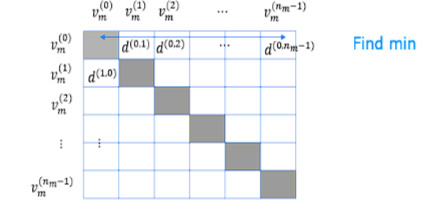

We can then find the closest movie by finding the minimum along each row. We will make use of [numpy masked arrays](https://numpy.org/doc/1.21/user/tutorial-ma.html) to avoid selecting the same movie. The masked values along the diagonal won't be included in the computation.

In [25]:
count = 50  # number of movies to display
dim = len(vms)
dist = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        dist[i,j] = sq_dist(vms[i, :], vms[j, :])
        
m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vecs[i,0])
    movie2_id = int(item_vecs[min_idx,0])
    disp.append( [movie_dict[movie1_id]['title'], movie_dict[movie1_id]['genres'],
                  movie_dict[movie2_id]['title'], movie_dict[movie1_id]['genres']]
               )
table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
table

movie1,genres,movie2,genres
Save the Last Dance (2001),Drama|Romance,Mona Lisa Smile (2003),Drama|Romance
"Wedding Planner, The (2001)",Comedy|Romance,Mr. Deeds (2002),Comedy|Romance
Hannibal (2001),Horror|Thriller,Final Destination 2 (2003),Horror|Thriller
Saving Silverman (Evil Woman) (2001),Comedy|Romance,Down with Love (2003),Comedy|Romance
Down to Earth (2001),Comedy|Fantasy|Romance,Bewitched (2005),Comedy|Fantasy|Romance
"Mexican, The (2001)",Action|Comedy,Rush Hour 2 (2001),Action|Comedy
15 Minutes (2001),Thriller,Panic Room (2002),Thriller
Enemy at the Gates (2001),Drama,Kung Fu Hustle (Gong fu) (2004),Drama
Heartbreakers (2001),Comedy|Crime|Romance,Fun with Dick and Jane (2005),Comedy|Crime|Romance
Spy Kids (2001),Action|Adventure|Children|Comedy,"Tuxedo, The (2002)",Action|Adventure|Children|Comedy


The results show the model will generally suggest a movie with similar genre's.

<a name="6"></a>
## 6 - Congratulations!
You have completed a content-based recommender system.    

This structure is the basis of many commercial recommender systems. The user content can be greatly expanded to incorporate more information about the user if it is available.  Items are not limited to movies. This can be used to recommend any item, books, cars or items that are similar to an item in your 'shopping cart'.

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://lh3.google.com/u/0/d/14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>